# Feature Ranking Algorithms

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mrmr import mrmr_classif

sns.set_style("whitegrid")

In [2]:
T = pd.read_csv("./data/pumpFeatures.csv")
X, y = T.iloc[:, :-1], T.faultCode
T.head()

,wMotor_mean,wMotor_std,wMotor_fftPeakIdx,wMotor_skewness,wMotor_kurtosis,wMotor_peak2peak,wMotor_peak2rms,wMotor_rms,wMotor_mad,wMotor_csRange,...,pOut_peak2peak,pOut_peak2rms,pOut_rms,pOut_mad,pOut_csRange,pOut_pLow,pOut_pMid,pOut_pHigh,pOut_pKur,faultCode
0,876.235677,6.204772,762,-0.164601,2.881123,39.070726,1.018288,876.257629,5.032113,1.225859e+06,...,0.125500,1.007635,7.226002,0.019002,10109.108199,0.000091,0.007472,0.001348,0.076296,0
1,876.238247,6.077463,762,-0.147077,2.673731,34.570767,1.016957,876.259308,4.982643,1.225862e+06,...,0.120924,1.007091,7.225622,0.018990,10108.578309,0.000118,0.006954,0.001434,0.076296,0
2,876.031159,6.250861,762,-0.123501,2.551445,35.491460,1.017266,876.053444,5.165914,1.225575e+06,...,0.131161,1.007494,7.225906,0.019032,10108.963684,0.000060,0.006570,0.001309,0.076296,0
3,876.196665,6.247495,762,-0.134596,2.728913,41.529486,1.018873,876.218921,5.093603,1.225799e+06,...,0.123254,1.007770,7.225914,0.018717,10108.973834,0.000066,0.007190,0.001364,0.076296,0
4,876.199734,6.095278,762,-0.139257,2.705275,36.096733,1.018066,876.220919,4.962708,1.225812e+06,...,0.123759,1.006735,7.225260,0.019078,10108.065292,0.000051,0.007814,0.001600,0.071808,0


This code fits a 5-fold cross-validated classification tree model to the original data, calculates the accuracy, and displays a confusion chart.

In [3]:
classifier = DecisionTreeClassifier()
kf = KFold(n_splits=5, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.905 0.805 0.82  0.875 0.905]
Mean accuracy: 0.8619999999999999
Cross validation elapsed time: 0.1940 seconds


<Figure size 640x480 with 0 Axes>

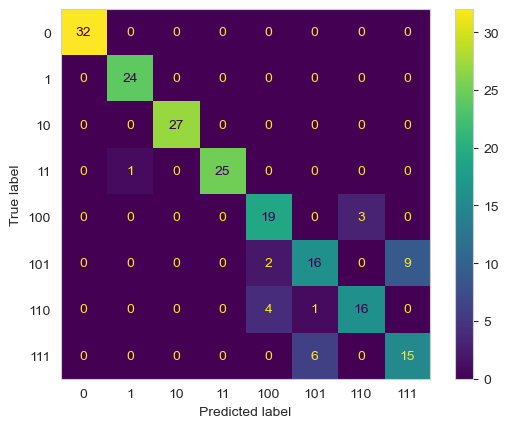

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_).plot();
plt.grid(False)
plt.show()

We can use the function [mrmr_classif()](https://github.com/smazzanti/mrmr) to rank the predictor variables according to the "minimum Redundancy - Maximum Relevance" algorithm.

In [5]:
# !pip install mrmr_selection

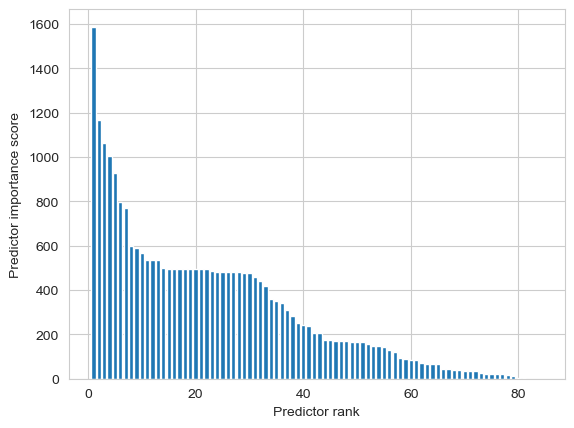

In [6]:
selected_features, relevance, redundancy = mrmr_classif(X=X, y=y, K=X.shape[1], return_scores=True, show_progress=False)

plt.figure()
plt.bar(range(1, X.shape[1]+1), relevance.sort_values(ascending=False))
plt.xlabel("Predictor rank")
plt.ylabel("Predictor importance score")
plt.show()

We can use logical indexing to select a subset of predictors according to their importance.

In [7]:
X_selected = X[relevance.sort_values(ascending=False)[:15].index]
X_selected.head()

,qIn_pMid,pIn_pMid,pOut_pMid,iMotor_pMid,wMotor_pMid,qOut_pMid,qIn_pHigh,iMotor_kurtosis,iMotor_skewness,qIn_peak2peak,pOut_rms,pOut_mean,pOut_csRange,qIn_rms,pIn_rms
0,169.684526,0.002516,0.007472,1.065793,664.057000,101.863840,37.590646,2.630745,-0.172052,23.305008,7.226002,7.225965,10109.108199,35.752511,0.149318
1,185.078227,0.003187,0.006954,1.294633,542.468686,97.377707,40.793426,2.538948,-0.144831,23.935700,7.225622,7.225584,10108.578309,35.784340,0.149758
2,171.390923,0.002865,0.006570,1.260542,705.149947,104.221784,40.856050,2.652137,-0.146612,23.413889,7.225906,7.225869,10108.963684,35.781533,0.149433
3,195.045437,0.003260,0.007190,1.250080,680.750727,112.976391,43.469277,2.649174,-0.166568,23.551698,7.225914,7.225877,10108.973834,35.723558,0.149457
4,189.889791,0.002155,0.007814,1.195977,674.780214,103.228468,42.245681,2.643513,-0.156826,22.501752,7.225260,7.225222,10108.065292,35.768517,0.150036


After selecting the predictors to use, we can fit a model to this subset and see how those affect the model performance.

In [8]:
classifier = DecisionTreeClassifier()
kf = KFold(n_splits=5, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X_selected, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.765 0.77  0.815 0.83  0.735]
Mean accuracy: 0.783
Cross validation elapsed time: 0.0660 seconds


<Figure size 640x480 with 0 Axes>

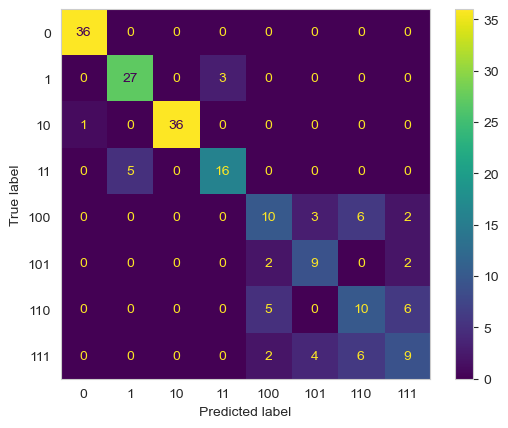

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_).plot();
plt.grid(False)
plt.show()